In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
import pickle
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.mixed_precision import set_global_policy, Policy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
from google.colab import drive
drive.mount('/content/drive')
#train_path = '/content/drive/My Drive/galaxies/train_data.pkl'
#test_path = '/content/drive/My Drive/galaxies/test_data.pkl'
all_path = '/content/drive/My Drive/galaxies/all_data.pkl'

Mounted at /content/drive


In [3]:
with open(all_path, 'rb') as f:
    images, labels = pickle.load(f)

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())
print(tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None))
!nvidia-smi

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Num GPUs Available:  1
True
True
Mon Dec 23 22:34:08 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0              25W /  70W |    103MiB / 15360MiB |      2%      Default |
|                                         |                      |                  N/A |
+----------------------------------

In [5]:
set_global_policy('mixed_float16')

## First testing with a pre-existing CNN architecture

In [6]:
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Flatten(),
    Dense(32, activation='relu', kernel_regularizer=l2(0.005)),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
m = model.fit(images, labels, epochs=15, validation_split=0.3, batch_size=64, shuffle=True)

Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 34s 843ms/step - accuracy: 0.3893 - loss: 1.2992 - val_accuracy: 0.5183 - val_loss: 1.0485
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.5322 - loss: 1.0411 - val_accuracy: 0.5300 - val_loss: 0.9764
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.5897 - loss: 0.9426 - val_accuracy: 0.6300 - val_loss: 0.8477
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.6180 - loss: 0.8959 - val_accuracy: 0.6483 - val_loss: 0.8430
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.6481 - loss: 0.8392 - val_accuracy: 0.6500 - val_loss: 0.8213
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.6108 - loss: 0.8856 - val_accuracy: 0.6800 - val_loss: 0.7763
Epoch 7/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.6612 - loss: 0.7681 - val_accuracy: 0.6983 - val_loss: 0.7660
Epoch 8/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.6946 - loss: 0.7362 - val_accuracy: 0.6533 

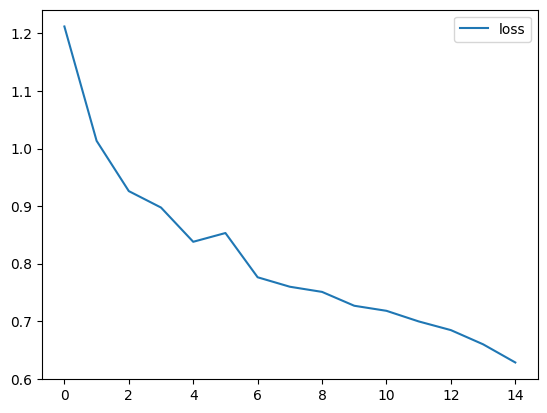

In [8]:
plt.plot(m.history['loss'], label='loss')
plt.legend()
plt.show()

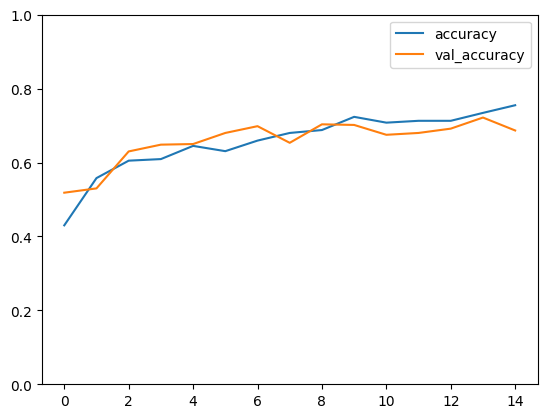

In [9]:
plt.plot(m.history['accuracy'], label='accuracy')
plt.plot(m.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.ylim(0, 1)
plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step


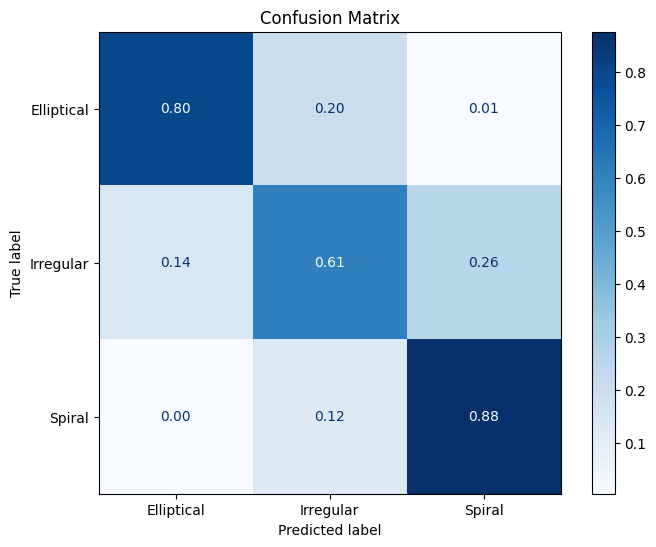

In [10]:
validation_split = 0.3
num_validation_samples = int(validation_split * len(labels))

all_indices = np.arange(len(labels))
validation_indices = np.random.choice(all_indices, num_validation_samples, replace=False)
validation_images = images[validation_indices]
validation_labels = labels[validation_indices]

y_pred = model.predict(validation_images).argmax(axis=1)
y_true = validation_labels

cm = confusion_matrix(y_true, y_pred)

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Elliptical', 'Irregular', 'Spiral'])
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format=".2f")

plt.title("Confusion Matrix")
plt.show()

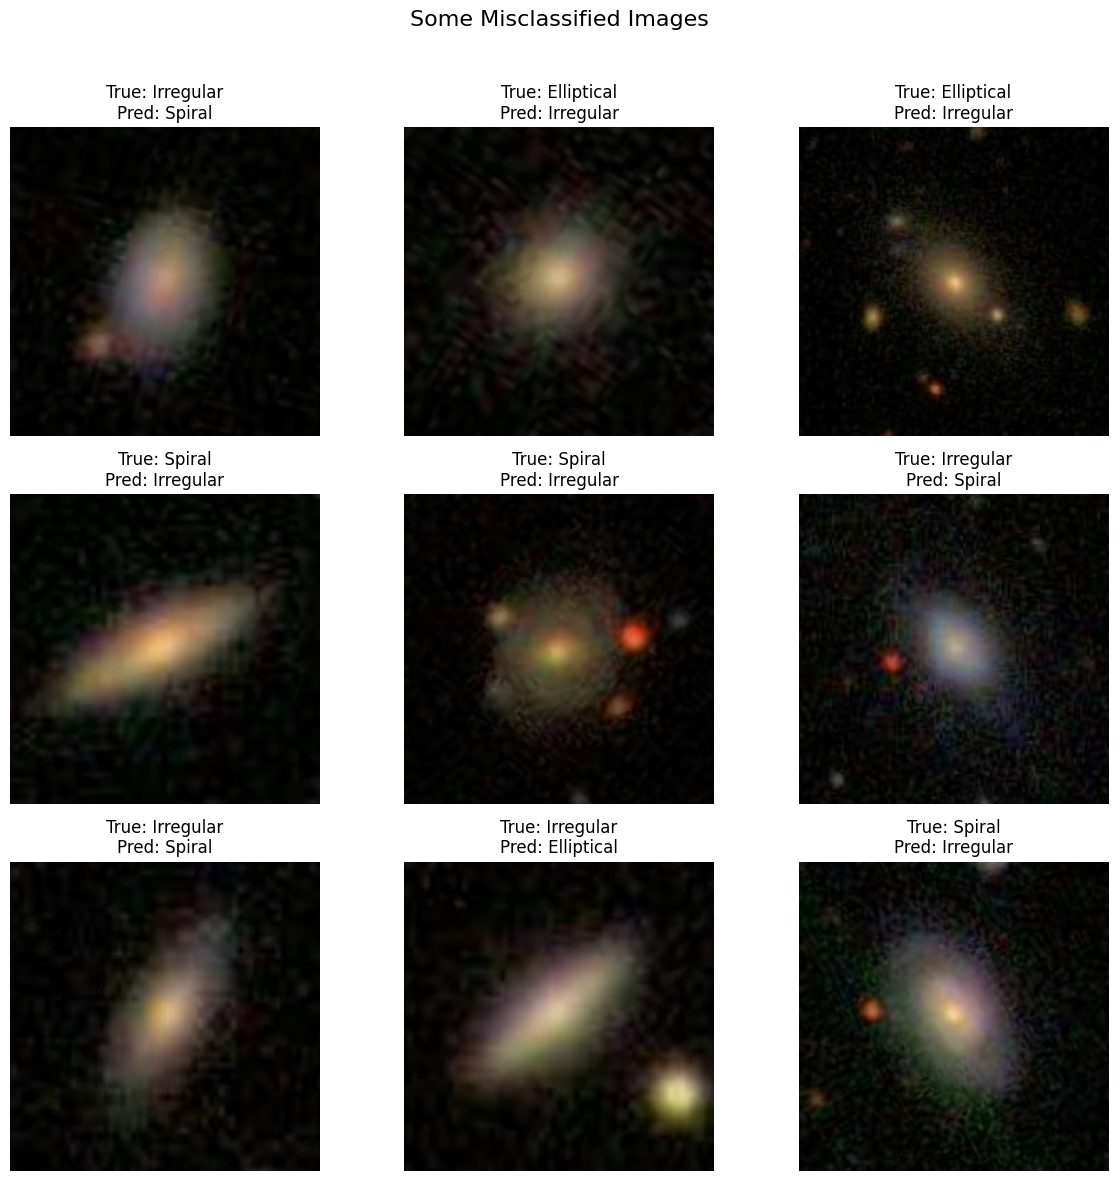

In [11]:
label_mapping = {0: "Elliptical", 1: "Irregular", 2: "Spiral"}

misclassified_indices = np.where(y_pred != y_true)[0]
n = 9

random_misclassified_indices = np.random.choice(misclassified_indices, min(len(misclassified_indices), n), replace=False)

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.suptitle("Some Misclassified Images", fontsize=16)

for i, ax in enumerate(axes.flat):
    idx = random_misclassified_indices[i]
    ax.imshow(validation_images[idx])
    ax.axis('off')
    true_label = label_mapping[y_true[idx]]
    predicted_label = label_mapping[y_pred[idx]]
    ax.set_title(f"True: {true_label}\nPred: {predicted_label}")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

After tweaking and playing around with the layers and parameters, the best I got is around low 70s on the test set.

It was possble to get higher accuracy on the training set, however it led to overfitting and there was a big gap between test and train accuracy. With my current parameters and layers, the accuracy for training and testing is growing together, showing no signs of overfitting.

The loss decreasing and the accuracies slowly increasing shows the model is effectively (although slowly) learning.

The confusion matrix is insightful as it shows that most spiral and elliptical gets labeled correctly, however it is much weaker with the irregular class, with a lot more being labeled incorrectly. This is not entirely surprising, since in the data extraction irregular was sort of used as a catch-all, and also there were less irregulars than spirals/ellipticals.

I will take this as a baseline and try to get close (maybe bypass but unlikely) with my CNN classifier from scratch.

## CNN architecture from scratch

### Convolutional Layer

In [12]:
class Conv2DLayer:
  """
  A 2D Convolutional Layer From Scratch
  """
  def __init__(self, num_filter, c):
      self.num_filter = num_filter
      self.filters = np.random.randn(num_filter, 3, 3, c) / 9

  def iterate(self, image):
      """
      Generator Function Which Extracts 3x3 Patches
      """
      h, w = image.shape[:2]

      for i in range(h - 2):
          for j in range(w - 2):
              patch = image[i : i + 3, j : j + 3, :]
              yield patch, i, j

  def forward(self, input):
      """
      Forward Pass on Conv Layer
      """
      batch_size, h, w, c = input.shape
      output = np.zeros((batch_size, h - 2, w - 2, self.num_filter))
      self.last = input

      for batch in range(batch_size):
          for region, i, j in self.iterate(input[batch]):
              for f in range(self.num_filter):
                  output[batch, i, j, f] = np.sum(region * self.filters[f, :, :, :])

      return output

  def backprop(self, dL_dout, learning_rate):
      """
      Backpropagation on Conv Layer
      """
      batch_size, out_h, out_w, out_c = dL_dout.shape
      dL_dF = np.zeros_like(self.filters)

      for b in range(batch_size):
          for patch, i, j in self.iterate(self.last[b]):
              for f in range(self.num_filter):
                  dL_dF[f] += patch * dL_dout[b, i, j, f]

      self.filters -= learning_rate * dL_dF
      return None

### Maxpool Layer

In [13]:
class Maxpool2DLayer:
  """
  A Maxpool Layer From Scratch
  """
  def iterate(self, image):
      """
      Generator Function Which Extracts Non-Overlapping 2x2 Patches
      """
      h, w = image.shape[:2]
      new_h = h // 2
      new_w = w // 2
      for i in range(new_h):
          for j in range(new_w):
              patch = image[(i * 2):(i * 2 + 2), (j * 2):(j * 2 + 2)]
              yield patch, i, j

  def forward(self, input):
      """
      Forward Pass on Maxpool Layer
      """
      batch_size, h, w, num_filters = input.shape
      output = np.zeros((batch_size, h // 2, w // 2, num_filters))
      self.last = input

      for b in range(batch_size):
          for patch, i, j in self.iterate(input[b]):
              output[b, i, j] = np.amax(patch, axis=(0, 1))
      return output

  def backprop(self, dL_dout):
      """
      Backpropagation on Maxpool Layer
      """
      batch_size, h, w, num_filters = self.last.shape
      dL_dinput = np.zeros(self.last.shape)

      for b in range(batch_size):
          for patch, i, j in self.iterate(self.last[b]):
              h, w, f = patch.shape
              amax = np.amax(patch, axis=(0, 1))

              for ii in range(h):
                  for jj in range(w):
                      for ff in range(f):
                          if patch[ii, jj, ff] == amax[ff]:
                              dL_dinput[b, i * 2 + ii, j * 2 + jj, ff] = dL_dout[b, i, j, ff]
      return dL_dinput

### Softmax Layer

In [14]:
class SoftmaxLayer:
  """
  A Softmax Layer From Scratch
  """
  def __init__(self, input_len, nodes):
      self.weights = np.random.randn(input_len, nodes) / input_len
      self.biases = np.zeros(nodes)

  def forward(self, input):
      """
      Forward Pass on Softmax Layer
      """
      self.last_shape = input.shape
      batch_size = input.shape[0]
      input = input.reshape(batch_size, -1)
      self.last_input = input

      input_len, nodes = self.weights.shape

      totals = np.dot(input, self.weights) + self.biases
      self.last_totals = totals

      exp = np.exp(totals - np.max(totals, axis=1, keepdims=True))
      return exp / np.sum(exp, axis=1, keepdims=True)

  def backprop(self, dL_dout, learning_rate):
      """
      Backpropagation on Softmax Layer
      """
      batch_size = dL_dout.shape[0]
      dL_dw = np.zeros_like(self.weights)
      dL_db = np.zeros_like(self.biases)
      dL_dinput = np.zeros_like(self.last_input)

      exp = np.exp(self.last_totals - np.max(self.last_totals, axis=1, keepdims=True))
      S = np.sum(exp, axis=1, keepdims=True)

      for i in range(batch_size):
          gradient = dL_dout[i]
          dout_dt = exp[i] * (S[i] - exp[i]) / (S[i] ** 2)

          dL_dw += np.outer(self.last_input[i], dout_dt)
          dL_db += dout_dt
          dL_dinput[i] = np.dot(self.weights, dout_dt)

      dL_dw /= batch_size
      dL_db /= batch_size

      self.weights -= learning_rate * dL_dw
      self.biases -= learning_rate * dL_db
      return dL_dinput.reshape(self.last_shape)

### Final Model

In [15]:
def compute_output_size(input_shape, conv_layers, pool_layers):
    h, w, c = input_shape[1:]
    for conv, pool in zip(conv_layers, pool_layers):
        h = (h - 2) // 2
        w = (w - 2) // 2
        c = conv.num_filter
    return h * w * c

In [16]:
class Model:
    def __init__(self):
        self.num_classes = 3
        self.conv1 = Conv2DLayer(16, 3)
        self.pool1 = Maxpool2DLayer()
        self.softmax = SoftmaxLayer(3600, self.num_classes)

    def forward(self, input):
        x = self.conv1.forward(input)
        x = self.pool1.forward(x)
        self.last_input_shape = x.shape
        batch_size = x.shape[0]
        x = x.reshape(batch_size, -1)
        logits = self.softmax.forward(x)
        return logits

    def train(self, train_data, train_labels, epochs, batch_size, learning_rate, validation_split=0.3):
        split_index = int(train_data.shape[0] * (1 - validation_split))
        train_data, val_data = train_data[:split_index], train_data[split_index:]
        train_labels, val_labels = train_labels[:split_index], train_labels[split_index:]

        for epoch in range(epochs):
            indices = np.arange(train_data.shape[0])
            np.random.shuffle(indices)
            train_data, train_labels = train_data[indices], train_labels[indices]

            for start in range(0, train_data.shape[0], batch_size):
                end = min(start + batch_size, train_data.shape[0])
                batch_data = train_data[start:end]
                batch_labels = train_labels[start:end]

                predictions = self.forward(batch_data)

                loss = self.loss(predictions, batch_labels)
                acc = self.accuracy(predictions, batch_labels)
                dL_dout = self.gradients(predictions, batch_labels)
                dL_dinput = self.softmax.backprop(dL_dout, learning_rate)
                dL_dinput = dL_dinput.reshape(self.last_input_shape)
                dL_dinput = self.pool1.backprop(dL_dinput)
                dL_dinput = self.conv1.backprop(dL_dinput, learning_rate)

            val_predictions = self.forward(val_data)
            val_loss = self.loss(val_predictions, val_labels)
            val_acc = self.accuracy(val_predictions, val_labels)

            print(f"Epoch: {epoch + 1}, Loss: {loss:.4f}, Accuracy: {acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

    def loss(self, predictions, labels):
        if len(labels.shape) == 1:
            labels = np.eye(self.num_classes)[labels]
        return -np.sum(labels * np.log(predictions + 1e-7)) / len(labels)

    def accuracy(self, predictions, labels):
        if len(predictions.shape) == 2:
            predictions = np.argmax(predictions, axis=1)

        if len(labels.shape) == 2:
            labels = np.argmax(labels, axis=1)

        return np.mean(predictions == labels)

    def gradients(self, predictions, labels):
        if len(labels.shape) == 1:
            labels = np.eye(self.num_classes)[labels]
        return predictions - labels

This is taking forever to run... I'm going to resize the images

In [17]:
import cv2

def resize(images, new_size=(64, 64)):
    resized_images = np.zeros((images.shape[0], new_size[0], new_size[1], images.shape[3]))

    for i in range(images.shape[0]):
        resized_images[i] = cv2.resize(images[i], new_size[:2])

    return resized_images

resized_imgs = resize(images, new_size=(32, 32))

In [18]:
model = Model()
model.train(resized_imgs, labels, epochs=5, batch_size=64, learning_rate=0.001)

Epoch: 1, Loss: 1.0986, Accuracy: 0.2857, Val Loss: 1.0985, Val Accuracy: 0.4067
Epoch: 2, Loss: 1.0983, Accuracy: 0.4286, Val Loss: 1.0985, Val Accuracy: 0.3783
Epoch: 3, Loss: 1.0985, Accuracy: 0.3750, Val Loss: 1.0985, Val Accuracy: 0.3600
Epoch: 4, Loss: 1.0985, Accuracy: 0.3036, Val Loss: 1.0986, Val Accuracy: 0.2883
Epoch: 5, Loss: 1.0989, Accuracy: 0.2321, Val Loss: 1.0987, Val Accuracy: 0.3100


So the model from scratch isn't ideal, it doesn't seem to be learning effectively and the loss doesn't really improve over epochs. I suspect there might be issues with how the gradient is calculated and/or with the backpropagation process.

I also think the model is struggling to learn and generalize because of compromises I made to speed up execution. For instance, I resized the images to a very low resolution (32x32) instead of 224x224, limited training to just 5 epochs instead of 15 (as I did in the Keras implementation), and used only a single convolutional and max-pooling layer.

The implementation's performance was also slowed down significantly by Python for-loops and manual patch iteration, even when using Colab's GPU runtime. I think using parallelization techniques and perhaps using more of tensorflow built-in functionalities while retaining the "from scratch" approach could have improved the execution speed without compromising the model's capability.

This was a great learning exercise and I learned a lot about the actual math that goes behind each layer and what purpose each layer serves in the overall picture of a convolutional neural network. I also learned how to create and improve a CNN architecture, as I was successful in getting the final accuracy of my keras model from sub 50 in my first few attempts to in the 70s in my final version.